### The Mandelbrot Set Iteration

The Mandelbrot set is given as the iteration of the following equations
$$
z_{n+1} = z^2_n + c
$$

Where:
* $z_0$ = 0 (starting value)
* $c$ is a complex number, where each unique $c$ will yield a different sequence of $z$ values

A point $c$ is in the Mandelbort set if, after iterating the equation multiple times, $|z|$ (the magnitude of $Z$) stays bounded (specifically, it remains $\leq$ 2). If $|z|$ escapes beyond 2, $c$ is not part of the set

## Imports


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from scipy.spatial import cKDTree
from multiprocessing import Pool

import colorsys

# Custom worker functions
from worker import (
    worker_function,
    worker_pure,
    worker_LHS,
    worker_orthogonal,
    worker_importance_random,
    worker_importance_LHS,
    worker_importance_orthogonal,
    get_example_samples,
    get_border_points
)


In [2]:

def mandelbrot(c_points, max_iter, escape_radius) -> tuple[np.array, np.array]:
    '''
    This function calculates the number of iterations until the magnitude of z escapes to infinity. 
    Within each iteration the z is updated with c, an imaginary number representing a grid point. 
    Ultimately, a mandelbrot is calculated. 
    '''
    iteration_count = np.zeros(c_points.shape)
    mandelbrot_set = np.zeros(c_points.shape, dtype=bool)
    for i in range(c_points.shape[0]):
        for j in range(c_points.shape[1]):

            # take a gridpoint
            c = c_points[i, j]
            z = 0
            for iteration in range(max_iter):

                # update of z
                z = z**2 + c
                if abs(z) > escape_radius:
                    mandelbrot_set[i, j] = False
                    iteration_count[i, j] =iteration
                    break
            else:
                mandelbrot_set[i, j] = True
                iteration_count[i, j] = max_iter
    return (mandelbrot_set, iteration_count)


            

# Plotting

#### Plotting different layouts of sampling methods

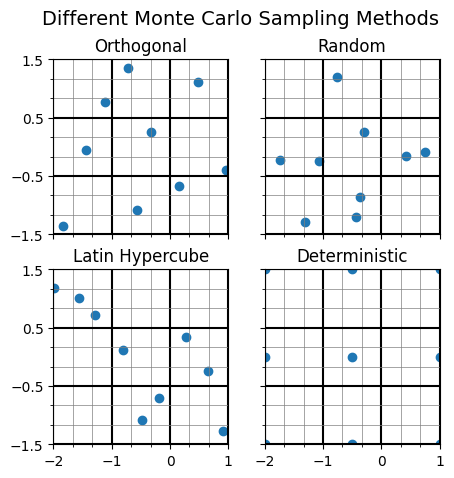

In [3]:

samples = 9 #root needs to be an int
random_seed = 57
(orth_samples, latin_samles, random_samples) = get_example_samples(samples, random_seed)

headers = ['Orthogonal', 'Latin Hypercube', 'Random', 'Deterministic' ]
fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharey=True, sharex=True)

real = np.linspace(-2.0, 1.0, int(np.sqrt(samples)))
imag = np.linspace(-1.5, 1.5, int(np.sqrt(samples)))

real_grid, imag_grid = np.meshgrid(real, imag)
coordinates_det = np.array(list(zip(real_grid.flatten(), imag_grid.flatten())))


j = 0
i = 0
for k, coordinates in enumerate([orth_samples, latin_samles, random_samples, coordinates_det]):
    if j == 0:
        if i > 1: 
            j += 1
            i -= 2
    
    ax = axes[i][j]
    ax.scatter(coordinates[:, 0], coordinates[:, 1])
    ax.set_xlim(-2, 1)
    ax.set_ylim(-1.5, 1.5)

    ax.set_aspect('equal', adjustable='box')  # Ensures 1:1 aspect ratio

    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)   # Thinner minor grid

    ax.set_xticks(np.linspace(-2, 1, samples+1), minor=True)  
    ax.set_yticks(np.linspace(-1.5, 1.5, samples+1), minor=True)

    ax.grid(which='major', color='black', linestyle='-', linewidth=1.5)  # Thicker major grid every 3 cells
    ax.set_xticks(np.linspace(-2, 1, int(samples/np.sqrt(samples)) + 1, endpoint=True))  
    ax.set_yticks(np.linspace(-1.5, 1.5, int(samples/np.sqrt(samples))+1, endpoint=True))

    ax.set_title(headers[k])
    # ax.miminorticks_on()
    i+=1

fig.suptitle('Different Monte Carlo Sampling Methods', fontsize=14)
plt.savefig("Sampling_layout.png", dpi=300)

plt.show()

### Plotting mandelbrot

In [12]:


def mandelbrot(c_points, max_iter, escape_radius) -> tuple[np.array, np.array]:
    '''
    This function calculates the number of iterations until the magnitude of z escapes to infinity. 
    Within each iteration the z is updated with c, an imaginary number representing a grid point. 
    Ultimately, a mandelbrot is calculated. 
    '''

    iteration_count = np.zeros(c_points.shape)
    mandelbrot_set = np.zeros(c_points.shape, dtype=bool)
    for i in range(c_points.shape[0]):
        for j in range(c_points.shape[1]):
            c = c_points[i, j]
            z = 0
            for iteration in range(max_iter):
                z = z**2 + c
                if abs(z) > escape_radius:
                    mandelbrot_set[i, j] = False
                    iteration_count[i, j] =iteration
                    break
                else:
                    mandelbrot_set[i, j] = True
                    iteration_count[i, j] = max_iter
    return (mandelbrot_set, iteration_count)

def custom_iteration_cmap():
    # Define colors for different iteration bounds
    yellow = np.array([1, 1, 0.2])       # for low iterations 
    green = np.array([0.2, 0.8, 0.2])    # for medium iterations 
    purple = np.array([0.5, 0.2, 0.8])   # for high iterations
    # color gradient
    n_colors = 256
    colors = np.zeros((n_colors, 3))
    # transitions between colors
    for i in range(n_colors):
        if i < n_colors // 3:
            # yellow to green
            t = i / (n_colors // 3)
            colors[i] = yellow * (1-t) + green * t
        else:
            # green to purple
            t = (i - n_colors // 3) / (2 * n_colors // 3)
            colors[i] = green * (1-t) + purple * t
    return ListedColormap(colors)


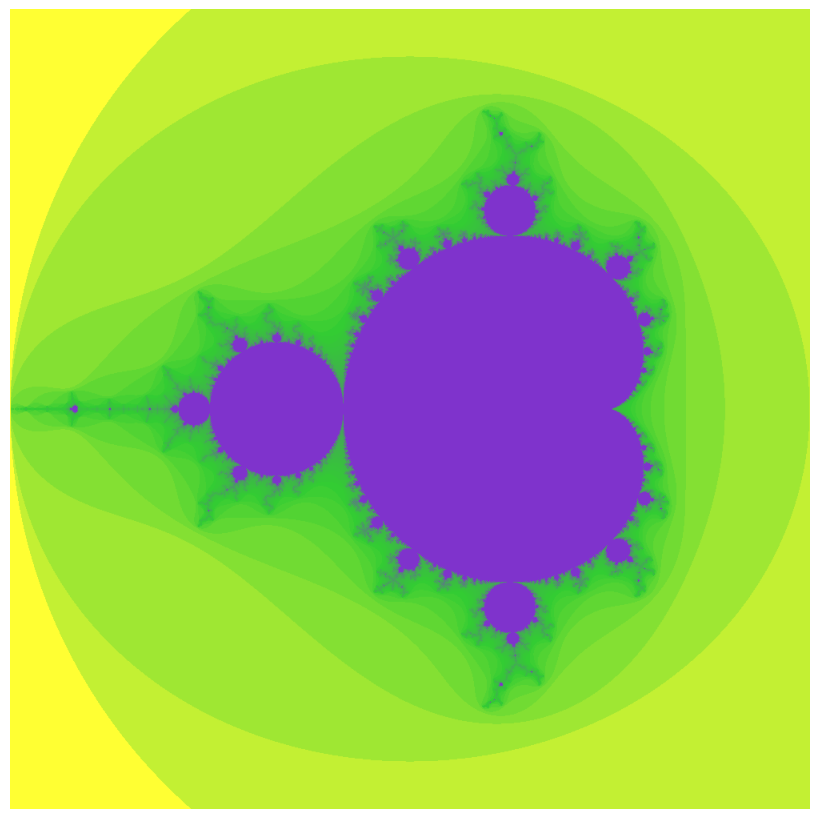

In [13]:
# setup the complex grid
real = np.linspace(-2.0, 1.0, 1000)
imag = np.linspace(-1.5, 1.5, 1000)
real_grid, imag_grid = np.meshgrid(real, imag)
c_points = real_grid + 1j * imag_grid

# calc the Mandelbrot set
max_iter = 1000
escape_radius = 2
mandel_set, iter_count = mandelbrot(c_points, max_iter, escape_radius)

custom_cmap = custom_iteration_cmap()
plt.figure(figsize=(12, 8))
plt.imshow(np.log(iter_count + 1),
          extent=(-2.0, 1.0, -1.5, 1.5),
          cmap=custom_cmap,
          origin='lower')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("mandelbrot_fig.png", dpi=300)
plt.show()

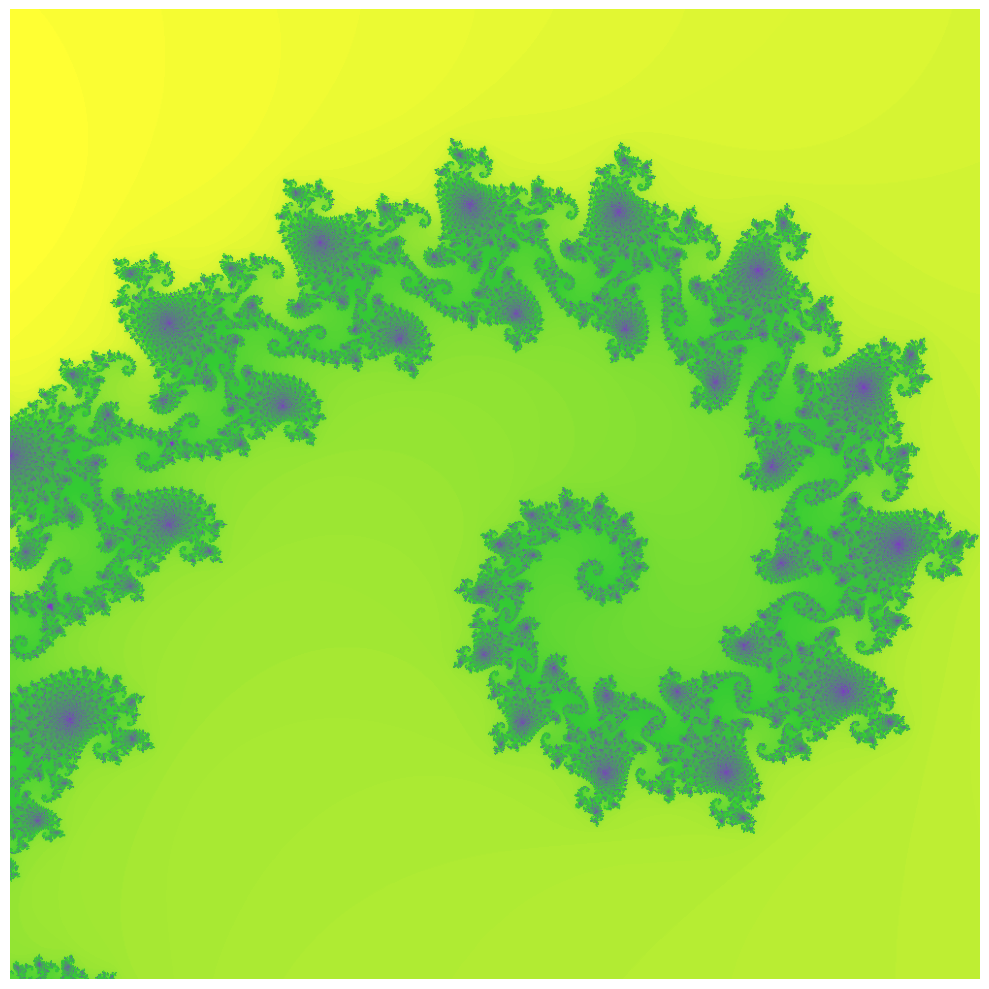

In [14]:
zoom_center = (-0.7435, 0.1314)  
zoom_width = 0.002             
zoom_real = np.linspace(zoom_center[0] - zoom_width/2,
                       zoom_center[0] + zoom_width/2, 1000)
zoom_imag = np.linspace(zoom_center[1] - zoom_width/2,
                       zoom_center[1] + zoom_width/2, 1000)
real_grid, imag_grid = np.meshgrid(zoom_real, zoom_imag)
c_points = real_grid + 1j * imag_grid

max_iter = 1000
escape_radius = 2
mandel_set, zoom_iter_count = mandelbrot(c_points, max_iter, escape_radius)

custom_cmap = custom_iteration_cmap()
plt.figure(figsize=(15, 10))
plt.imshow(np.log(zoom_iter_count + 1),
          extent=(zoom_real[0], zoom_real[-1], zoom_imag[0], zoom_imag[-1]),
          cmap=custom_cmap,
          origin='lower')
plt.grid(True, alpha=0.3, linestyle='--')
plt.axis('off')
plt.tight_layout()
plt.savefig("mandelbrot_fig_zoomed.png", dpi=300)
plt.show()


### Reading .txt file and processing data of the sampling methods

In [15]:
df_l = pd.read_csv("latin.txt", header=1)  # Set header=None since there is no header in the file

# Assign column labels
df_l.columns = ["grid_size", "max_iterations", "run", "total_points", "points_inside"]
df_l['fraction'] = (1- df_l['points_inside'] / df_l['total_points'])*9
df_l['error'] = 1.506484 - (1- df_l['points_inside'] / df_l['total_points'])*9

variance_error = df_l.groupby(['grid_size', 'max_iterations'])['error'].var()
mean_error = df_l.groupby(['grid_size', 'max_iterations'])['error'].mean()
average_fraction = df_l.groupby(['grid_size', 'max_iterations'])['fraction'].mean()
variance_fraction = df_l.groupby(['grid_size', 'max_iterations'])['fraction'].var()

# creating a data frame with mean and variance of every group for latin hypercube
mean_var_l = pd.DataFrame({
    'mean': average_fraction,
    'variance': variance_fraction, 
    'variance_error': variance_error, 
    'mean_error': mean_error
}).reset_index()

df_o = pd.read_csv("orthogonal.txt", header=1)  # Set header=None since there is no header in the file

# Assign column labels
df_o.columns = ["grid_size", "max_iterations", "run", "total_points", "points_inside"]
df_o['fraction'] = (1- df_o['points_inside'] / df_o['total_points'])*9
df_o['error'] = 1.506484 - (1- df_o['points_inside'] / df_o['total_points'])*9

variance_error_o = df_o.groupby(['grid_size', 'max_iterations'])['error'].var()
mean_error_o = df_o.groupby(['grid_size', 'max_iterations'])['error'].mean()
average_fraction_o = df_o.groupby(['grid_size', 'max_iterations'])['fraction'].mean()
variance_fraction_o = df_o.groupby(['grid_size', 'max_iterations'])['fraction'].var()

# creating a data frame with mean and variance of every group for latin hypercube
mean_var_o = pd.DataFrame({
    'mean': average_fraction_o,
    'variance': variance_fraction_o, 
    'variance_error': variance_error_o, 
    'mean_error': mean_error_o
}).reset_index()

# Read the data from the file
df_r = pd.read_csv("random.txt", header=1)  # Set header=1 since the first row is the header

# Assign column labels
df_r.columns = ["grid_size", "max_iterations", "run", "total_points", "points_inside"]

# Calculate 'fraction' and 'error'
df_r['fraction'] = (1 - df_r['points_inside'] / df_r['total_points']) * 9
df_r['error'] = 1.506484 - (1 - df_r['points_inside'] / df_r['total_points']) * 9

# Compute grouped statistics
variance_error_r = df_r.groupby(['grid_size', 'max_iterations'])['error'].var()
mean_error_r = df_r.groupby(['grid_size', 'max_iterations'])['error'].mean()
average_fraction_r = df_r.groupby(['grid_size', 'max_iterations'])['fraction'].mean()
variance_fraction_r = df_r.groupby(['grid_size', 'max_iterations'])['fraction'].var()

# Create a DataFrame with mean and variance for each group
mean_var_r = pd.DataFrame({
    'mean': average_fraction_r,
    'variance': variance_fraction_r, 
    'variance_error': variance_error_r, 
    'mean_error': mean_error_r
}).reset_index()

#### Plotting the deterministic results

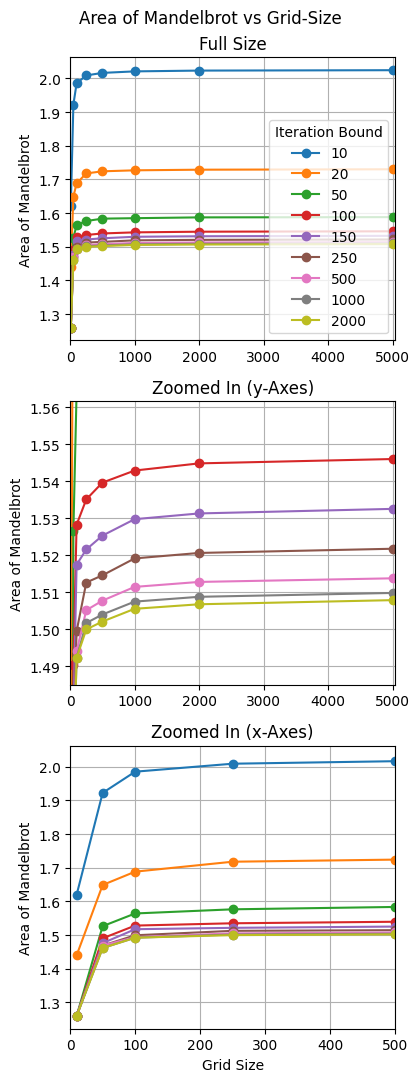

In [16]:
# plotting the results from deterministic sampling, Area as a function of the grid-size
df = pd.read_csv("question2.txt", delimiter=",", skiprows=1,
                 names=["grid_size", "max_iterations", "total_points", "points_inside"])
df["fraction_mand"] = (1 - df["points_inside"]/df["total_points"])*9

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(4.3, 11))
for max_iter, group in df.groupby("max_iterations"):
    ax1.plot(group["grid_size"], group["fraction_mand"], label=f"{max_iter}", marker= 'o')
    ax2.plot(group["grid_size"], group["fraction_mand"], label=f"{max_iter}", marker= 'o')
    ax3.plot(group["grid_size"], group["fraction_mand"], label=f"{max_iter}", marker= 'o')

# full plot
ax1.set_ylabel("Area of Mandelbrot")
ax1.set_title("Full Size")
ax1.legend(title="Iteration Bound")
ax1.set_xlim(0, 5040)
ax1.grid(True)

# for max_iter, group in df.groupby("max_iterations"):
    

# zoomed in plot on the y-axes
ax2.set_ylabel("Area of Mandelbrot")
ax2.set_title("Zoomed In (y-Axes)")
ax2.set_xlim(0, 5040)
ax2.grid(True)
ax2.set_ylim(0.165*9, 0.1735*9)

# zooming in on x-axes
ax3.set_ylabel("Area of Mandelbrot")
ax3.set_xlabel("Grid Size")
ax3.set_title("Zoomed In (x-Axes)")
ax3.set_xlim(0, 5040)
ax3.grid(True)
ax3.set_xlim(0, 500)

fig.suptitle("Area of Mandelbrot vs Grid-Size")
plt.tight_layout()
plt.savefig("Area_deterministic.png", dpi=300)
plt.show()


#### Plotting mean and standard error orthogonal

C:\Users\chris\AppData\Local\Temp\ipykernel_30528\1482301395.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


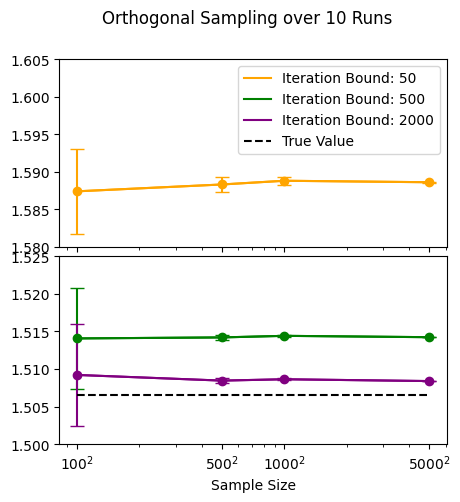

In [17]:


colors = ["orange", "green", "purple"]
fig, (ax1, ax2) = plt.subplots(2,1, sharex= True, figsize=(5,5), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})
# bax = brokenaxes(ylims=((1.5, 1.525), (1.58, 1.595)), hspace=.05) 
i = 0
for name, group in mean_var_o.groupby("max_iterations"):
    ax1.plot(group['grid_size'], group['mean'], color=colors[i], label=f"Iteration Bound: {name}")
    ax1.errorbar(group['grid_size'], group["mean"], yerr=np.sqrt(group['variance']), fmt='o-', color=colors[i], capsize=5)

    # Plot on ax2 without labels to avoid duplicating in the legend
    ax2.plot(group['grid_size'], group['mean'], color=colors[i])
    ax2.errorbar(group['grid_size'], group["mean"], yerr=np.sqrt(group['variance']), fmt='o-', color=colors[i], capsize=5)

    i += 1

ax2.plot(group['grid_size'], [1.506484]*4, color='black', linestyle= '--', label='True Value')
ax1.plot(group['grid_size'], [1.506484]*4, color='black', linestyle= '--', label='True Value')
ax1.legend()
# ax2.legend()

ax1.set_ylim(1.58, 1.605)
ax2.set_ylim(1.5, 1.525)

# Set log scale on x-axis
ax1.set_xscale("log")
ax2.set_xscale("log")

custom_ticks = [100, 500, 1000, 5000]
ax2.set_xticks(custom_ticks)  # Set tick positions
ax2.set_xticklabels([f"${tick}^2$" for tick in custom_ticks])
ax2.set_xlabel("Sample Size")
plt.suptitle("Orthogonal Sampling over 10 Runs")
plt.tight_layout()
plt.savefig("orthogonal_mean.png", dpi=300)
plt.show()

#### plotting mean and standard error latin hypercube

C:\Users\chris\AppData\Local\Temp\ipykernel_30528\3454108755.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


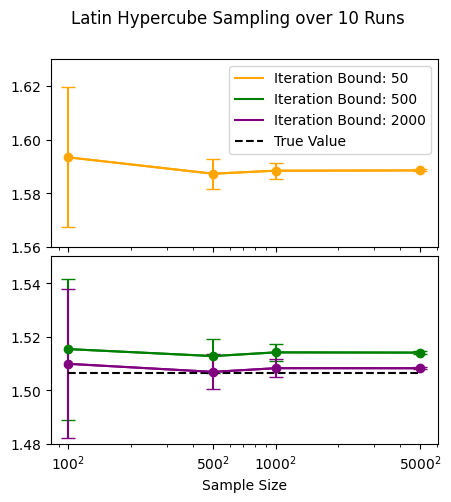

In [18]:

colors = ["orange", "green", "purple"]
fig, (ax1, ax2) = plt.subplots(2,1, sharex= True, figsize=(5,5), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})
i = 0
for name, group in mean_var_l.groupby("max_iterations"):
    ax1.plot(group['grid_size'], group['mean'], color=colors[i], label=f"Iteration Bound: {name}")
    ax1.errorbar(group['grid_size'], group["mean"], yerr=np.sqrt(group['variance']), fmt='o-', color=colors[i], capsize=5)

    # Plot on ax2 without labels to avoid duplicating in the legend
    ax2.plot(group['grid_size'], group['mean'], color=colors[i])
    ax2.errorbar(group['grid_size'], group["mean"], yerr=np.sqrt(group['variance']), fmt='o-', color=colors[i], capsize=5)

    i += 1

# plotting true value
ax2.plot(group['grid_size'], [1.506484]*4, color='black', linestyle= '--', label='True Value')
ax1.plot(group['grid_size'], [1.506484]*4, color='black', linestyle= '--', label='True Value')
ax1.legend()

# Plot finetuning
ax1.set_ylim(1.56, 1.63)
ax2.set_ylim(1.48, 1.55)
ax1.set_xscale("log")
ax2.set_xscale("log")

custom_ticks = [100, 500, 1000, 5000]
ax2.set_xticks(custom_ticks)  # Set tick positions
ax2.set_xticklabels([f"${tick}^2$" for tick in custom_ticks])
ax2.set_xlabel("Sample Size")
fig.suptitle("Latin Hypercube Sampling over 10 Runs")
plt.tight_layout()
plt.savefig("Latin_mean.png", dpi=300)
plt.show()


#### plotting mean and standard deviation random

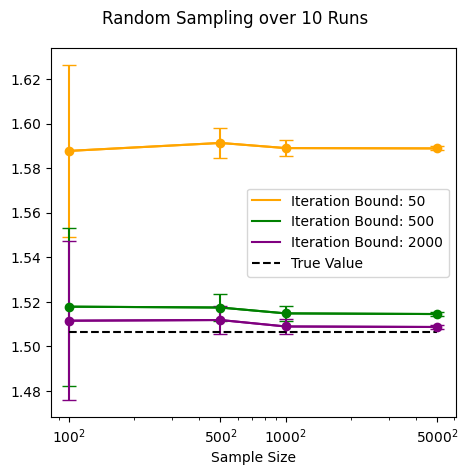

In [19]:


colors = ["orange", "green", "purple"]
fig, ax = plt.subplots(1,1, sharex= True, figsize=(4.8,4.8))
i = 0

# plot mean and std for every line
for name, group in mean_var_r.groupby("max_iterations"):
    ax.plot(group['grid_size'], group['mean'], color=colors[i], label=f"Iteration Bound: {name}")
    ax.errorbar(group['grid_size'], group["mean"], yerr=np.sqrt(group['variance']), fmt='o-', color=colors[i], capsize=5)
    i += 1

ax.plot(group['grid_size'], [1.506484]*4, color='black', linestyle= '--', label='True Value')
ax.legend()
ax.set_xscale("log")

custom_ticks = [100, 500, 1000, 5000]
ax.set_xticks(custom_ticks)  # Set tick positions
ax.set_xticklabels([f"${tick}^2$" for tick in custom_ticks])
ax.set_xlabel("Sample Size")
fig.suptitle("Random Sampling over 10 Runs")
plt.tight_layout()
plt.savefig("random_sampling.png", dpi=300)
plt.show()



#### Reading in values from the importance sampling method

In [21]:
list_vals =[]
average_imp_fraction = []
average_error_imp =[]
variance_fraction_imp = []
variance_error_imp = []
for i, name in enumerate(['random', 'latin', 'orthogonal']):

    df_imp = pd.read_csv(f'improved_{name}_sampling_1.txt', header=1)
    
    df_imp.columns = ['grid_size', 'max_iterations', 'run', 'total_points', 'points_inside']
    df_imp['fraction'] = (1 - df_imp['points_inside'] / df_imp['total_points']) * 9
    df_imp['abs_error'] = 1.506484 - (1 - df_imp['points_inside'] / df_imp['total_points']) * 9

    average_imp_fraction.append(df_imp.groupby(['grid_size', 'max_iterations'])['fraction'].mean())
    variance_fraction_imp.append(df_imp.groupby(['grid_size', 'max_iterations'])['fraction'].var())
    average_error_imp.append(df_imp.groupby(['grid_size', 'max_iterations'])['abs_error'].mean())
    variance_error_imp.append(df_imp.groupby(['grid_size', 'max_iterations'])['abs_error'].var())
    
mean_imp_var = pd.DataFrame({
    'mean_r': average_imp_fraction[0],
    'variance_r':variance_fraction_imp[0], 
    'abs_error_r':average_error_imp[0],
    'variance_error_r':variance_error_imp[0],
    'mean_l': average_imp_fraction[1],
    'variance_l':variance_fraction_imp[1],
    'abs_error_l':average_error_imp[1], 
    'variance_error_l':variance_error_imp[1],
    'mean_o': average_imp_fraction[2],
    'variance_o':variance_fraction_imp[2],
    'abs_error_o':average_error_imp[2],
    'variance_error_o':variance_error_imp[2]
}).reset_index()



#### Plotting variances

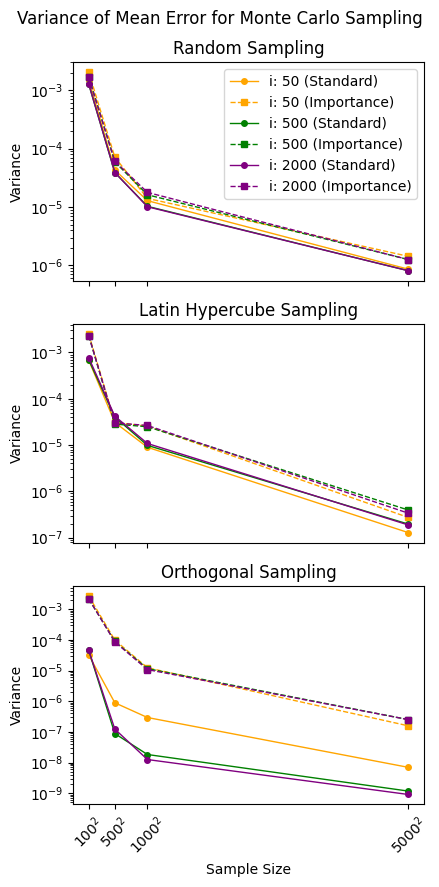

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(4.5, 9), sharex=True)
fig.suptitle("Variance of Mean Error for Monte Carlo Sampling")

# Plot for Random Sampling

iterate_names= ['variance_error_r', 'variance_error_l', 'variance_error_o']

for j, m_v in enumerate([mean_var_r, mean_var_l, mean_var_o]):
    i = 0
    for name, group in m_v.groupby("max_iterations"):
        axes[j].plot(group["grid_size"], group['variance_error'], marker='o', linewidth = 1, markersize=4, color=colors[i], label=f'i: {name} (Standard)')
        imp_group = mean_imp_var[mean_imp_var['max_iterations'] == name]
        axes[j].plot(imp_group["grid_size"], imp_group[iterate_names[j]], marker='s', color=colors[i], linewidth = 1, markersize=4,  linestyle = '--', label=f'i: {name} (Importance)')
        i += 1
    # axes[j].set_xlabel("Sample Size")
    axes[j].set_yscale("log")
    axes[j].set_ylabel("Variance")

axes[0].set_title("Random Sampling")
axes[0].legend()
axes[1].set_title("Latin Hypercube Sampling")
axes[2].set_title("Orthogonal Sampling")

axes[2].set_xlabel("Sample Size")
axes[2].set_xticks([100, 500, 1000, 5000])
axes[2].set_xticklabels([f"${tick}^2$" for tick in [100, 500, 1000, 5000]], rotation=45)
plt.tight_layout()  # Adjust layout to fit the main title
plt.savefig('variances.png', dpi=300)
plt.show()


#### Plotting mean absolute errors

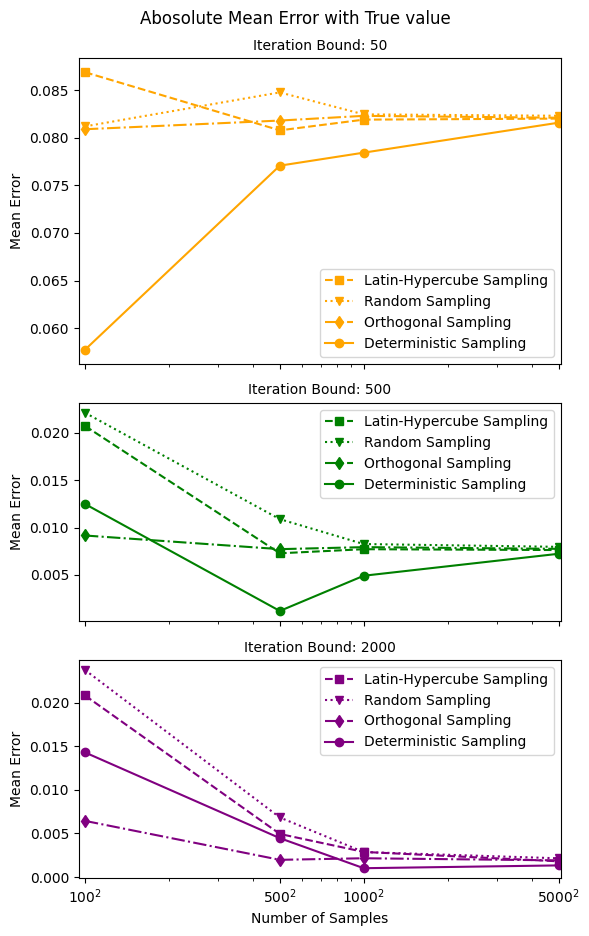

In [23]:
df = pd.read_csv("question2.txt", delimiter=",", skiprows=1,
                 names=["grid_size", "max_iterations", "total_points", "points_inside"])
df["fraction"] = (1 - df["points_inside"]/df["total_points"])*9
true_value = [1.506484]*len(df['fraction'])
df["diff_true"] = np.abs(true_value-df['fraction'])


true_value = [1.506484]*len(df_l['fraction'])
df_l["diff_true"] = np.abs(true_value-df_l['fraction'])
average_diff_l = df_l.groupby(['grid_size', 'max_iterations'])['diff_true'].mean()
variance_diff_l = df_l.groupby(['grid_size', 'max_iterations'])['diff_true'].var()


true_value = [1.506484]*len(df_o['fraction'])
df_o["diff_true"] = np.abs(true_value-df_o['fraction'])

average_diff_o = df_o.groupby(['grid_size', 'max_iterations'])['diff_true'].mean()
variance_diff_o = df_o.groupby(['grid_size', 'max_iterations'])['diff_true'].var()

true_value = [1.506484]*len(df_r['fraction'])
df_r["diff_true"] = np.abs(true_value-df_r['fraction'])

average_diff_r = df_r.groupby(['grid_size', 'max_iterations'])['diff_true'].mean()
variance_diff_r = df_r.groupby(['grid_size', 'max_iterations'])['diff_true'].var()

mean_var_diff = pd.DataFrame({
    'mean_o': average_diff_o,
    'variance_o': variance_diff_o,
    'mean_l': average_diff_l,
    'variance_l': variance_diff_l, 
    'mean_r': average_diff_r,
    'variance_r': variance_diff_r
}).reset_index()


grid_sizes = [100, 500, 1000, 5000]
grid_sub_df = df[(df['grid_size'].isin(grid_sizes))].reset_index()

fig, axes = plt.subplots(3, 1,sharex=True,figsize=(6,9.5), gridspec_kw={'height_ratios': [1.4, 1, 1]})
i = 0
for name, group in mean_var_diff.groupby("max_iterations"):
    ax = axes[i]
    ax.plot(group['grid_size'], group['mean_l'], marker='s', color=colors[i], linestyle='--', label=f"Latin-Hypercube Sampling")
    # ax.errorbar(group['grid_size'], group["mean_l"], yerr=np.sqrt(group['variance_l']), fmt='o', color=colors[i], capsize=5)

    ax.plot(group['grid_size'], group['mean_r'], marker='v', color=colors[i], linestyle=':', label=f"Random Sampling")
    # ax.errorbar(group['grid_size'], group["mean_r"], yerr=np.sqrt(group['variance_l']), fmt='o', color=colors[i], capsize=5)

    ax.plot(group['grid_size'], group['mean_o'], marker='d', color=colors[i], linestyle='-.', label=f"Orthogonal Sampling")
    # ax.errorbar(group['grid_size'], group["mean_o"], yerr=np.sqrt(group['variance_o']), fmt='o', color=colors[i], capsize=5)

    deterministic_val= grid_sub_df[grid_sub_df["max_iterations"] == name]
    ax.plot(group['grid_size'], deterministic_val['diff_true'], marker='o', color=colors[i], label='Deterministic Sampling')

    ax.set_xscale("log")
    ax.set_ylabel("Mean Error")
    ax.set_title(f"Iteration Bound: {name}", fontsize=10)
    ax.legend()
    i += 1

axes[2].set_xlim(95, 5100)
custom_ticks = [100, 500, 1000, 5000]
axes[2].set_xticks(custom_ticks)  # Set tick positions
axes[2].set_xticklabels([f"${tick}^2$" for tick in custom_ticks])
axes[2].set_xlabel("Number of Samples")
fig.suptitle("Abosolute Mean Error with True value")
plt.tight_layout()

plt.savefig('difference_act_value.png', dpi=300)
plt.show()

#### Plotting border (for importance sampling)

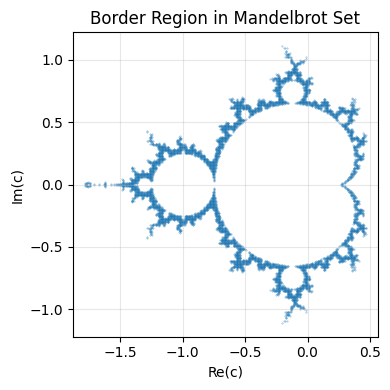

In [24]:
diff_array=get_border_points(500, 2000, 15)
plt.figure(figsize=(4,4))
plt.scatter(diff_array[:, 0], diff_array[:, 1], s=0.1, alpha=0.6)
plt.title('Border Region in Mandelbrot Set')
plt.xlabel('Re(c)')
plt.xlim(-2, 1)
plt.ylim(-1.5, 1.5)
plt.ylabel('Im(c)')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.savefig("boundary.png", dpi=300)
plt.show()

# Implementing Sampling methods

#### Orthogonal Sampling

In [ ]:

def partition_func(pars):
    '''
    This function parallelizes the simulation, by assigning different proc different parametersets. 
    It utilizes asynchronic parallelization, meaning the output is printed after the task is finished
    '''
    PROCESSES = 10 
    dict_res = {}
    with Pool(PROCESSES) as pool:  # Adjust the number of processes as needed 
        print("Starting parallel execution")
        # asynchronyc parallelization
        for res in pool.imap_unordered(worker_orthogonal,  pars):
            (tot_points, out_points), par = res
            dict_res[par] = (tot_points, out_points)
            print(f"Gridsize: {par[0]}, Iteration Bound:{par[1]}, Run: {par[2]}\n Total points and points inside mandelbrot: {tot_points, out_points}", flush=True)
    return dict_res

if __name__ == '__main__':
    
    # These are the values to experiment with, test with dummy values (these are quicker)
    # s_values = [50, 500, 2000]
    # grids = [100, 500, 1000, 5000]

    # Dummy values
    s_values = [10, 50, 60, 70]
    grids = [7, 31, 71, 101]
    par_combos = []

    # make sure the number of procs you use does not exceed the processor count
    print(f"Number of available CPU cores: {os.cpu_count()}")
    
    # 10 runs
    for i in range(10):
        # provide random seed such that random function will be different
        random_seed = i+42

        # every proc gets a full grid, every proc a different parameter set (defined above)
        for g in grids:
            for s in s_values:
                par_combos.append( (g, s, i, random_seed))

    saved_values = {}
    saved_values = partition_func(par_combos)

    # ensure saving the values with this code:
    with open("orthogonal_dummy.txt", "w") as file:
        file.write("grid_size, max_iterations, run, total_points, points_inside\n")
        for (key1, key2, run), (value1, value2)  in saved_values.items():
            file.write(f"{key1}, {key2}, {run}, {value1}, {value2}\n")


#### Latin hypercube

In [ ]:


def partition_func(pars):
    '''
    This function parallelizes the simulation, by assigning different proc different parametersets. 
    It utilizes asynchronic parallelization, meaning the output is printed after the task is finished
    '''
    # max 10 processes
    PROCESSES = 10 
    dict_res = {}
    with Pool(PROCESSES) as pool:  # Adjust the number of processes as needed 
        print("Starting parallel execution")
        for res in pool.imap_unordered(worker_LHS,  pars):
            (tot_points, out_points), par = res
            dict_res[par] = (tot_points, out_points)
            print(f"Gridsize: {par[0]}, Iteration Bound:{par[1]}, Run: {par[2]}\n Total points and points inside mandelbrot: {tot_points, out_points}", flush=True)
    return dict_res

if __name__ == '__main__':
    
    # These are the values to experiment with, test with dummy values (these are quicker)
    s_values = [50, 500, 2000]
    grids = [100, 500, 1000, 5000]

    # Dummy values
    s_values = [10, 50, 60, 70]
    grids = [7, 31, 71, 101]

    par_combos = []
    
    print(f"Number of available CPU cores: {os.cpu_count()}")
    
    # 10 runs
    for i in range(10):
        # provide random seed such that random function will be different
        random_seed = i+42

        # every proc gets a full grid, every proc a different parameter set (defined above)
        for g in grids:
            
            for s in s_values:
                par_combos.append( (g, s, i, random_seed))

    saved_values = {}
    saved_values = partition_func(par_combos)

    # ensure saving the values with this code:
    with open("latin-dummy.txt", "w") as file:
        # add parameter in case a parameter is added to the 
        file.write("grid_size, max_iterations, run, total_points, points_inside\n")
        for (key1, key2, run), (value1, value2)  in saved_values.items():
            file.write(f"{key1}, {key2}, {run}, {value1}, {value2}\n")


#### Deterministic Sampling 

In [ ]:


def partition_grid(grid, proc):
    '''
    divides the grid evenly through all processes. Row wise partition. 
    '''
    grid_size = grid//proc
    rest = grid % proc

    indexes =[]
    index = 0

    real = np.linspace(-2.0, 1.0, grid)
    imag = np.linspace(-1.5, 1.5, grid)

    # Create a 2D grid of complex numbers c
    real_grid, imag_grid = np.meshgrid(real, imag)
    c_points = real_grid + 1j * imag_grid

    for _ in range(proc):
        if rest > 0:
            addit = 1
            rest -=1
        else: 
            addit = 0
        indexes.append((index, index+grid_size+addit))
        index += grid_size + addit
    
    c_slices = [c_points[start:end] for start, end in indexes]
    return c_slices


def driver_func(grid, s):

    # max 10 processes
    PROCESSES = 10 
    with Pool(PROCESSES) as pool:  # Adjust the number of processes as needed 

        # every process gets a fraction of the grid (row-wise partitioning)
        c_parts = partition_grid(grid, PROCESSES)

        args = [(c_slice, s) for c_slice in c_parts]
        results = pool.map(worker_function,  args)
        total_points_parts, inside_points_parts = zip(*results)
        total_points = sum(total_points_parts)
        inside_points= sum(inside_points_parts)
        print(f"Result: {results}\nTotal points and points inside mandelbrot: {total_points, inside_points}")
    return total_points, inside_points

if __name__ == '__main__':
    # # experimental values 
    # s_values = [10, 20, 50, 100, 150, 250, 500, 1000, 2000]
    # grids = [10, 50, 100, 250, 500, 1000, 2000, 5000]
    
    # dummy values
    s_values = [10, 20, 50, 100,]
    grids = [10, 50, 100, 250]
    
    saved_values = {}
    # make sure the number of procs you use does not exceed the processor count
    print(f"Number of available CPU cores: {os.cpu_count()}")
    for grid in grids:
        for s_value in s_values:
            key = (grid, s_value)
            tot_points, in_points = driver_func(grid, s_value)
            saved_values[key] = (tot_points, in_points)
            
    with open("deterministic-dummy.txt", "w") as file:
        file.write("grid_size, max_iterations, total_points, points_inside\n")
        for (key1, key2), (value1, value2)  in saved_values.items():
            file.write(f"{key1}, {key2}, {value1}, {value2}\n")

#Since the mandelbrot is symmetrical, we could halve the grid and get the same fraction 

#### Random Sampling 

In [ ]:
def partition_random(pars):
    '''
    Assign a task (different parameterset) to every proc once it is free. 
    Prints output of a task once it is finsihed. 
    Returns fraction of points outside of mandelbrot as dictionary
    '''
    PROCESSES = 10
    dict_res = {}
    with Pool(PROCESSES) as pool:
        for res in pool.imap_unordered(worker_pure, pars):
            (tot_points, in_points), par = res
            dict_res[par] = (tot_points, in_points)
            estimated_area = (1-(in_points / tot_points)) * 9
            print(f"Grid-Size: {par[0]}, Iterations: {par[1]}, run: {par[2]}, Area: {estimated_area:.6f}")
    return dict_res

if __name__ == "__main__":
    # variables for experimentation
    s_values = [50, 500, 2000]
    grids = [100, 500, 1000, 5000]

    # dummy values
    s_values = [50, 100, 200]
    grids = [100, 200, 300]

    par_combos = []
    for i in range(10):
        for size in grids:
            for max_iter in s_values:
                
                # update rand for uniqueness across different runs
                rand = 42+i
                par_combos.append((size, max_iter, i, rand))
    print(f"Number of available CPU cores: {os.cpu_count()}")
    saved_values = partition_random(par_combos)

    dict_temp = {}
    # save values to .txt file
    with open('random_temp.txt', 'w') as file:
        file.write('grid_size, max_iterations, run, total_points, points_inside\n')
        for (key1, key2, key3), (value1, value2) in saved_values.items():
            file.write(f"{key1}, {key2}, {key3}, {value1}, {value2}\n")
            if (key1, key2) not in dict_temp:
                dict_temp[(key1, key2)] = []
        
            # Append the calculated value to the list
            dict_temp[(key1, key2)].append(abs((value1 - value2) / value1 * 9-1.506484))
        for (item1, item2), values in dict_temp.items(): 
            print(f'{item1, item2}, waarde: {np.var(values)}')


## Importance Sampling Method

In [ ]:
def partition_func(pars, method='random'):
    PROCESSES = 14
    dict_res = {}
    worker_function = (
            worker_importance_random if method == 'random'
            else worker_importance_LHS if method == 'latin'
            else worker_importance_orthogonal
        )

    with Pool(PROCESSES) as pool:
        print(f"Starting parallel execution for {method} sampling")
        for res in pool.imap_unordered(worker_function,pars):
            (tot_points, out_points), par = res
            dict_res[par] = (tot_points, out_points)
            estimated_area = (tot_points-out_points)/tot_points * 9
            print(f"Method: {method}, Grid-Size: {par[0]}, Iteration Bound: {par[1]}, run: {par[2]}, Area: {estimated_area:.6f}")
    return dict_res

if __name__ == '__main__':

    # dummy values
    grids = [100, 500] 
    s_values = [50, 500]

    # # experimental values
    # grids = [100, 500, 1000, 5000]
    # s_values = [50, 500, 2000]
    # Add CPU core check
    print(f"Number of available CPU cores: {os.cpu_count()}")
     # Calculate border points once
    
    # estimate border points an build a tree, use this tree for the distance function -> is used to calculate g(x) upon which is resampled
    border_points = get_border_points(500, 2000, 15)
    border_tree = cKDTree(border_points)
    if border_tree is None: 
        print("Tree Function is not working")
    
    par_combos = []
    
    for i in range(10):
        for iter in s_values:
            for size in grids:
                # ensure uniqueness across runs by updating random seed
                rand = 42+i
                par_combos.append((size, iter, i, rand, border_points, border_tree))
    
    # iterate over all methods 
    methods = [ 'random', 'orthogonal', 'latin'] 
    
    for method in methods:
        print(f"\nProcessing {method} sampling method...")
        saved_values = partition_func(par_combos, method=method)
        
        filename = f"dummy_improved_{method}.txt"
        print(f"Saving results to {filename}")
        dict_temp = {}
        with open(filename, "w") as file:
            file.write("grid_size, iteration bound, run, total_points, points_inside\n")
            for (key1, key2, key3), (value1, value2) in saved_values.items():
                file.write(f"{key1}, {key2}, {key3}, {value1}, {value2}\n")
                if (key1, key2) not in dict_temp:
                    dict_temp[(key1, key2)] = []
        
                # Append the calculated value to the list
                dict_temp[(key1, key2)].append(abs((value1 - value2) / value1 * 9 - 1.506484))
        for (item1, item2), values in dict_temp.items(): 
            print(f'{item1, item2}, variance: {np.var(values)}')
            print(f'{item1, item2}, mean_diff: {np.mean(values)}')

                
